### Load data


In [ ]:
!pip install --user mlmicrophysics==0.1.1

In [ ]:
import argparse
import random
import sys
import yaml
from os.path import join, exists
import os
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import tree
import tensorflow as tf

from mlmicrophysics.metrics import heidke_skill_score, peirce_skill_score, hellinger_distance, root_mean_squared_error, r2_corr
from mlmicrophysics.models import DenseNeuralNetwork
from mlmicrophysics.data import subset_data_files_by_date, assemble_data_files


# set random seed
seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# define data parameters

data_path = "ncar-aiml-data-commons/microphysics"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    out_path = "/content/gdrive/My Drive/micro_models/base"
else:
    out_path = "./micro_models/base/"
if not exists(out_path):
    os.makedirs(out_path)
subsample = 0.1
input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qrtend_TAU", "nctend_TAU", "nrtend_TAU"]

subset_data = {"train_date_start" : 0,
               "train_date_end" : 11000,
               "test_date_start" : 11100,
               "test_date_end" : 17500}

input_scaler = StandardScaler()
input_transforms = {"QC_TAU_in" : "log10_transform",
                    "NC_TAU_in" : "log10_transform",
                    "QR_TAU_in" : "log10_transform",
                    "NR_TAU_in" : "log10_transform"}

output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
                                   0: ["==", 0, "zero_transform", "None"],
                                   1: [">", 0, "log10_transform", "StandardScaler"]}}


In [ ]:
# Load data from disk or cloud
# Separate input, output and meta data
# Split into training, validation, and test sets

print("Subsetting file paths by train, validation, and test")
train_files, val_files, test_files = subset_data_files_by_date(data_path, **subset_data)

print("\nLoading training data")
scaled_input_train, \
labels_train, \
transformed_out_train, \
scaled_out_train, \
output_scalers, \
meta_train = assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                 output_transforms, input_scaler, subsample=subsample)

print("\nLoading testing data")
scaled_input_test, \
labels_test, \
transformed_out_test, \
scaled_out_test, \
output_scalers_test, \
meta_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                output_transforms, input_scaler, output_scalers=output_scalers,
                                train=False, subsample=subsample)


Subsetting file paths by train, validation, and test


NameError: ignored

In [ ]:
# save meta data, input scalers, and output scalers
    
meta_test.to_csv(join(out_path, "meta_test.csv"), index_label="index")

input_scaler_df = pd.DataFrame({"mean": input_scaler.mean_, "scale": input_scaler.scale_},
                               index=input_cols)
input_scaler_df.to_csv(join(out_path, "input_scale_values.csv"), index_label="input")

out_scales_list = []
for var in output_scalers.keys():
    for out_class in output_scalers[var].keys():
        if output_scalers[var][out_class] is not None:
            out_scales_list.append(pd.DataFrame({"mean": output_scalers[var][out_class].mean_,
                                                 "scale": output_scalers[var][out_class].scale_},
                                                index=[var + "_" + str(out_class)]))
out_scales_df = pd.concat(out_scales_list)
out_scales_df.to_csv(join(out_path, "output_scale_values.csv"),
                     index_label="output")
out_scales_df

,mean,scale
qrtend_TAU_1,-11.190049,2.089005
nctend_TAU_1,-0.172256,2.584713
nrtend_TAU_-1,-3.434289,2.271458
nrtend_TAU_1,-2.084925,1.801713


## Monday: Create an exploratory visualization of the data

In [ ]:
# Histograms of original training input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(transformed_input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

NameError: ignored

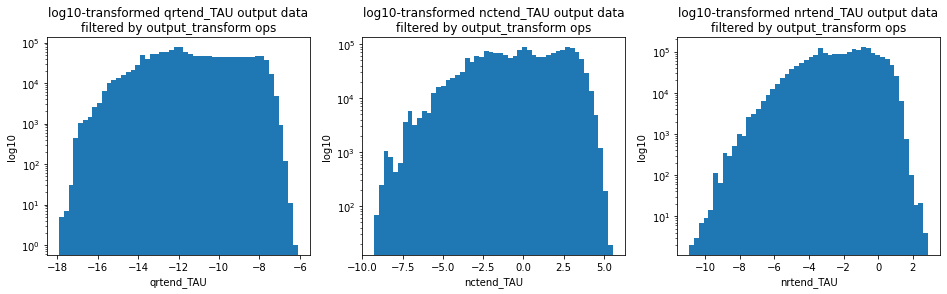

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
for output_col, ax in zip(output_cols, (ax1, ax2, ax3)):
    original_out_train_nc = np.zeros(scaled_out_train.shape[0])
    original_out_train_nc[labels_train[output_col] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == 1, [output_col]]).ravel()
    original_out_train_nc[labels_train[output_col] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == -1, [output_col]]).ravel()
    ax.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
    ax.set_xlabel(output_col)
    ax.set_ylabel('log10')
    ax.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
    ax.set_yscale('log')


In [ ]:
# Inverse transform and scaling of scaled train data

original_out_train_nr = np.zeros(scaled_out_train.shape[0])
original_out_train_nr[labels_train["nrtend_TAU"] == 1] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == 1, ["nrtend_TAU"]]).ravel()
original_out_train_nr[labels_train["nrtend_TAU"] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == -1, ["nrtend_TAU"]]).ravel()


original_out_train_nc = np.zeros(scaled_out_train.shape[0])
original_out_train_nc[labels_train["nctend_TAU"] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nctend_TAU"] == 1, ["nctend_TAU"]]).ravel()

original_out_train_qr = np.zeros(scaled_out_train.shape[0])
original_out_train_qr[labels_train["qrtend_TAU"] == 1] = 10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, ["qrtend_TAU"]]).ravel()


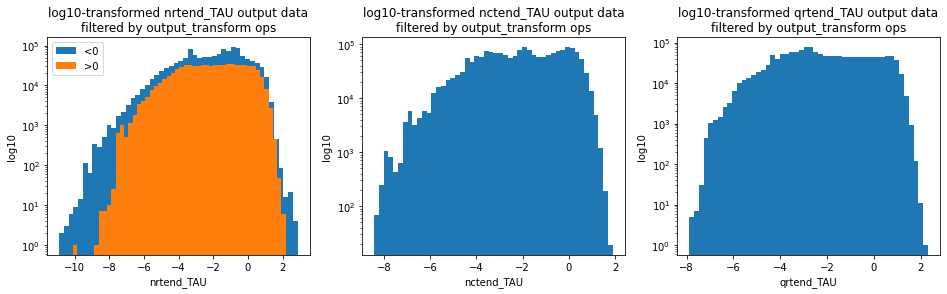

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.hist(np.log10(-original_out_train_nr[original_out_train_nr < 0]), bins=50, label="<0")
ax1.hist(np.log10(original_out_train_nr[original_out_train_nr > 0]), bins=50, label=">0")
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
ax2.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
ax3.hist(np.log10(original_out_train_qr[original_out_train_qr > 0]), bins=50)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()


In [ ]:
# load and view a single file

fs = s3fs.S3FileSystem(anon=True)
filenames = fs.ls("s3://ncar-aiml-data-commons/microphysics")
fobj = fs.open(filenames[0])
single_file = pd.read_parquet(fobj).set_index('Index')
single_file.head()

## Tuesday's Modeling

In [ ]:
# Tuesday's code goes here

!pip install keras

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# specify model with 2 hidden layers
model = Sequential()
model.add(Dense(4, input_dim=5, activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# train
history = model.fit(scaled_input_train, scaled_out_train, epochs=100, batch_size=1000)

,lat,lev,lon,P0,PS,depth,row,col,hyam,hybm,...,precip_frac,qctend_MG2,qctend_TAU,nctend_MG2,nctend_TAU,qrtend_MG2,qrtend_TAU,nrtend_MG2,nrtend_TAU,time
Index,,,,,,,,,,,,,,,,,,,,,
0,-88.115183,957.48548,28.75,100000.0,68814.664,29,2,23,0.006255,0.951231,...,0.5,-1.315998e-15,-2.864113e-25,-0.012213,-0.000461,1.315998e-15,0.0,0.000020,0.0,0.0
1,-88.115183,957.48548,30.00,100000.0,68741.100,29,2,24,0.006255,0.951231,...,0.5,-2.648823e-14,-5.759241e-25,-0.072859,-0.026884,2.648823e-14,0.0,0.000405,0.0,0.0
2,-88.115183,957.48548,31.25,100000.0,68667.195,29,2,25,0.006255,0.951231,...,1.0,-3.268663e-14,3.867864e-25,-0.108811,-0.059724,3.268663e-14,0.0,0.000499,0.0,0.0
3,-88.115183,957.48548,32.50,100000.0,68593.090,29,2,26,0.006255,0.951231,...,1.0,-8.188127e-14,-2.839463e-24,-0.187248,-0.176943,8.188127e-14,0.0,0.001251,0.0,0.0
4,-88.115183,957.48548,33.75,100000.0,68518.980,29,2,27,0.006255,0.951231,...,1.0,-1.991433e-13,2.097941e-24,-0.301633,-0.443875,1.991433e-13,0.0,0.003043,0.0,0.0


## Wednesday: Relevant Metrics
1. A confusion matrix of outputs from the original model.

In [ ]:
# Wednesday's code goes here

def plot_confusion_matrices(confusion_matrix_dict):
    import seaborn as sns

    titles = list(confusion_matrix_dict.keys())
    N_plots = len(titles)
    fig, axes = plt.subplots(1, N_plots, figsize=(5*N_plots+1,4))
    # Get labels from variables above.
    labels_dict = {'qrtend_TAU':[0,1], 'nctend_TAU':[0,1], 'nrtend_TAU':[-1,0,1]}
    for ax, title in zip(axes, titles):
        matrix = confusion_matrix_dict[title]
        labels = labels_dict[title]
        
        df_cm = pd.DataFrame(matrix, index = labels, columns = labels)
        sns.heatmap(df_cm, annot=True, cbar=True, ax=ax, fmt=",")
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

if DAY == 3:
    # Plot confusion matrices for the original model run provided with the exercise.
    plot_confusion_matrices(confusion_matrices)